In [1]:
import matplotlib.pyplot as plt
import pandas as pd

In [23]:
import numpy as np

# Generate theta and calculate y = sin(theta)
def generate_theta(num_elements):
    theta = np.linspace(0, np.pi/2, num_elements)
    return theta

def calculate_sin(theta):
    y = np.sin(theta)
    return y

def calculate_tan(theta):
    y = np.tan(theta)
    return y

# Calculate second derivative using central difference
def central_difference_second_derivative(y, theta, h):
    y_double_prime = np.zeros_like(y)

    for i in range(1, len(y) - 1):
        y_double_prime[i] = (y[i+1] - 2*y[i] + y[i-1]) / h**2

    return y_double_prime

# Calculate midpoints and errors
def calculate_x_with_max_error(theta, y):
    # x = arccos(m) is the point with max error
    x_with_max_error = np.zeros(len(y)-1)
    for i in range(1, len(y)):
        slope = (y[i] - y[i-1]) / (theta[i] - theta[i-1])
        x_with_max_error[i-1] = np.arccos(slope)

    interpolated_y = y[:-1] + (y[1:] - y[:-1]) / (theta[1:] - theta[:-1]) * (x_with_max_error - theta[:-1])
    actual_y = np.sin(x_with_max_error)
    errors = np.abs(actual_y - interpolated_y)

    # Find the index of the maximum error
    max_error_index = np.argmax(errors)
    max_error = errors[max_error_index]

    # Find the corresponding theta pair
    theta_pairs = [(theta[i], theta[i+1]) for i in range(len(theta) - 1)]
    max_error_theta_pair = theta_pairs[max_error_index]

    return max_error, errors, max_error_theta_pair


# Main function to adjust num_elements based on tolerance with adaptive step size
def optimize_elements(tolerance):
    num_elements = 10  # Initial guess for number of elements
    max_iterations = 100  # Max number of iterations to avoid infinite loop
    iteration = 0

    while iteration < max_iterations:
        theta = generate_theta(num_elements)
        y = calculate_sin(theta)

        # Calculate the second derivative
        y_double_prime = central_difference_second_derivative(y, theta, theta[1] - theta[0])

        # Calculate errors and get the max error
        max_error, errors, max_error_theta_pair = calculate_x_with_max_error(theta, y)

        # Adaptive step size calculation
        error_ratio = max_error / tolerance
        print(f"Iteration {iteration}: num_elements = {num_elements}, max_error = {max_error}")

        if max_error > tolerance:
            # Increase num_elements based on how large the error is compared to the tolerance
            step_size = int(num_elements * error_ratio * 0.5)  # Adjust the scaling factor as needed
            num_elements += max(1, step_size)  # Ensure at least 1 element is added
        elif max_error < tolerance * 0.5:
            # Decrease num_elements based on how far below the tolerance the error is
            step_size = int(num_elements * (1 - error_ratio) * 0.5)  # Adjust scaling factor
            num_elements -= max(1, step_size)  # Ensure at least 1 element is subtracted
        else:
            # If within acceptable tolerance, break
            break

        # Avoid going below 5 elements
        if num_elements < 5:
            num_elements = 5
            break

        iteration += 1  # Increment iteration count

    if iteration == max_iterations:
        print("Max iterations reached. The solution may not have converged.")

    # Once converged, find the max absolute second derivative
    max_second_derivative = np.max(np.abs(y_double_prime))
    corresponding_angle = theta[np.argmax(np.abs(y_double_prime))]

    # Print results
    print(f"For num_elements = {num_elements}:")
    print(f"Max error = {max_error:.6f}, between = {max_error_theta_pair}")
    print(f"Max second derivative = {max_second_derivative:.6f} at theta = {corresponding_angle:.4f}")

    return num_elements, max_error, max_second_derivative, y_double_prime, corresponding_angle


In [3]:
def refine_theta_based_on_second_derivative_and_tolerance(theta, y, max_second_derivative_original, tolerance):
    new_theta = np.copy(theta)  # Create a copy of theta to modify
    new_y = np.copy(y)          # Copy y as well for calculations
    h = theta[1] - theta[0]
    len_of_new_theta = len(new_theta)

    for i in range(1, len_of_new_theta - 1):  # Iterate from 1 to len(new_theta) - 2
        # Temporarily remove the element at index i
        if(i >= len(new_theta)-1):
            break
        temp_theta = np.delete(new_theta, i)
        temp_y = np.sin(temp_theta)

        # Calculate the second derivative for the modified theta
        y_double_prime = non_uniform_central_difference_second_derivative(temp_y, temp_theta)
        max_error, errors, max_error_theta_pair = calculate_x_with_max_error(temp_theta, temp_y)

        # Find the max absolute second derivative in the updated array
        max_second_derivative = np.max(np.abs(y_double_prime))

        # Compare with the original max second derivative
        if max_second_derivative <= max_second_derivative_original or True:
            # Keep the element removed if the new max second derivative and new max error is smaller
            if max_error <= tolerance:
              new_theta = temp_theta  # Update new_theta permanently
              new_y = temp_y          # Update new_y permanently
              len_of_new_theta = len(new_theta)
        else:
            # If the new max is larger, restore the removed element by skipping to next
            continue

    return new_theta, new_y


In [4]:
def non_uniform_central_difference_second_derivative(y, theta):
    y_double_prime = np.zeros_like(y)

    for i in range(1, len(y) - 1):
        h1 = theta[i] - theta[i-1]  # Spacing between theta[i] and theta[i-1]
        h2 = theta[i+1] - theta[i]  # Spacing between theta[i+1] and theta[i]

        # Second derivative using non-uniform central difference formula
        y_double_prime[i] = (2 / (h1 + h2)) * ((y[i+1] - y[i]) / h2 - (y[i] - y[i-1]) / h1)

    return y_double_prime

In [5]:
# Get tolerance from user and run the optimization
tolerance = 0.0005  # float(input("Enter the tolerance value: "))

# After running optimize_elements
num_elements, max_error, max_second_derivative_original, y_double_prime, corresponding_angle = optimize_elements(tolerance)
theta = generate_theta(num_elements)
y = calculate_sin(theta)

# Refine theta based on second derivative
new_theta, new_y = refine_theta_based_on_second_derivative_and_tolerance(theta, y, max_second_derivative_original, tolerance)
new_theta, new_y, len(new_theta)

Iteration 0: num_elements = 10, max_error = 0.0037908277228748677
Iteration 1: num_elements = 47, max_error = 0.00014573378653603974
Iteration 2: num_elements = 31, max_error = 0.0003425576027423771
For num_elements = 31:
Max error = 0.000343, between = (1.5184364492350666, 1.5707963267948966)
Max second derivative = 0.998401 at theta = 1.5184


(array([0.        , 0.10471976, 0.20943951, 0.31415927, 0.41887902,
        0.4712389 , 0.52359878, 0.57595865, 0.62831853, 0.68067841,
        0.73303829, 0.78539816, 0.83775804, 0.89011792, 0.9424778 ,
        0.99483767, 1.04719755, 1.09955743, 1.15191731, 1.20427718,
        1.25663706, 1.30899694, 1.36135682, 1.41371669, 1.46607657,
        1.51843645, 1.57079633]),
 array([0.        , 0.10452846, 0.20791169, 0.30901699, 0.40673664,
        0.4539905 , 0.5       , 0.54463904, 0.58778525, 0.62932039,
        0.66913061, 0.70710678, 0.74314483, 0.77714596, 0.80901699,
        0.83867057, 0.8660254 , 0.89100652, 0.91354546, 0.93358043,
        0.95105652, 0.96592583, 0.9781476 , 0.98768834, 0.9945219 ,
        0.99862953, 1.        ]),
 27)

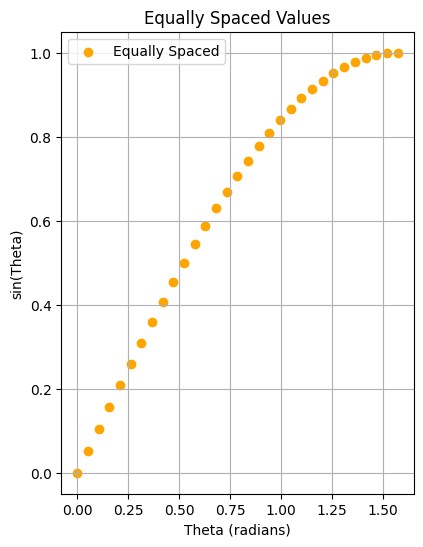

In [6]:
# Create the figure and axis
plt.figure(figsize=(10, 6))

# Plot equally spaced values
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.scatter(theta, y, color='orange', label='Equally Spaced')
plt.title('Equally Spaced Values')
plt.xlabel('Theta (radians)')
plt.ylabel('sin(Theta)')
plt.grid()
plt.legend()

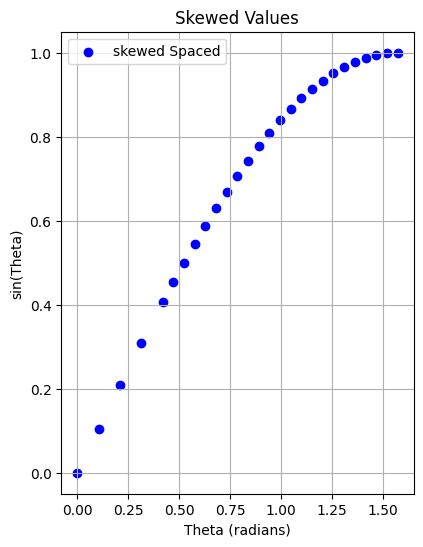

In [7]:
# Create the figure and axis
plt.figure(figsize=(10, 6))

# Plot equally spaced values
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.scatter(new_theta, new_y, color='blue', label='skewed Spaced')
plt.title('Skewed Values')
plt.xlabel('Theta (radians)')
plt.ylabel('sin(Theta)')
plt.grid()
plt.legend()

In [8]:
# Function to perform linear interpolation using central difference
def linear_interpolation(x, y, angle):
    neg_side = 1
    # When angle is greater than 360, find angle % 360
    if angle > 4*x[-1]:
        angle = angle%(4*x[-1])
    # When angle is negative, sin(-x) = -sin(x)
    elif angle < 0:
        angle = -1 * angle
        neg_side = -1

    # When angle between 0 and 90 degree, return sin(angle)
    if angle >= x[0] and angle <= x[-1]:
        for i in range(len(x) - 1):
            if x[i] <= angle <= x[i + 1]:
                return neg_side * (y[i] + (angle - x[i]) * (y[i + 1] - y[i]) / (x[i + 1] - x[i]))
    # When angle between 90 and 180, return sin(180 - angle)
    elif angle > x[-1] and angle <= 2*x[-1]:
        angle = 2*x[-1] - angle
        for i in range(len(x) - 1):
            if x[i] <= angle <= x[i + 1]:
                return neg_side * (y[i] + (angle - x[i]) * (y[i + 1] - y[i]) / (x[i + 1] - x[i]))
    # When angle between 180 and 270, return -sin(angle)
    elif angle > 2*x[-1] and angle <= 3*x[-1]:
        angle = angle - 2*x[-1]
        for i in range(len(x) - 1):
            if x[i] <= angle <= x[i + 1]:
                return -1 * neg_side * (y[i] + (angle - x[i]) * (y[i + 1] - y[i]) / (x[i + 1] - x[i]))
    # When angle between 180 and 360, return -sin(360 - angle)
    elif angle > 3*x[-1] and angle <= 4*x[-1]:
        angle = 4*x[-1] - angle
        for i in range(len(x) - 1):
            if x[i] <= angle <= x[i + 1]:
                return -1 * neg_side * (y[i] + (angle - x[i]) * (y[i + 1] - y[i]) / (x[i + 1] - x[i]))
    else:
        return None  # Unexpected value

In [9]:
# Function to find sine value and perform interpolation if necessary
def get_sine_value(angle, theta, sine):
    sine_value = linear_interpolation(theta, sine, angle)
    actual_value = np.sin(angle)

    error = actual_value - sine_value if sine_value is not None else None
    relative_error = error / actual_value if error is not None and actual_value != 0 else None

    return {
        'Angle': angle*180/np.pi,
        'Sine Approx': sine_value,
        'Error': error,
        'Relative Error': relative_error,
        'Actual Sine': actual_value
    }

In [10]:
test_angles = np.random.uniform(0, 200*np.pi, 100)
test_angles = [angle for angle in test_angles]

In [11]:
# Calculate results for the entered test angles
results = []
for angle in test_angles:
    result = get_sine_value(angle, new_theta, new_y)
    results.append(result)

# Create a DataFrame for results
results_sin = pd.DataFrame(results)
results_sin

,Angle,Sine Approx,Error,Relative Error,Actual Sine
0,3336.742025,0.992832,0.000253,0.000255,0.993085
1,1432.320746,-0.133463,-0.000164,0.001231,-0.133627
2,19768.459032,-0.522929,-0.000179,0.000342,-0.523108
3,12271.762984,0.526233,0.000174,0.000330,0.526407
4,19073.644363,-0.110656,-0.000043,0.000390,-0.110699
...,...,...,...,...,...
95,11722.881593,-0.388522,-0.000306,0.000788,-0.388828
96,15810.724767,-0.488885,-0.000121,0.000247,-0.489005
97,15708.502482,-0.748840,-0.000145,0.000193,-0.748984
98,18408.945463,0.753860,0.000224,0.000297,0.754085


In [12]:
# check if all errors are within the tolerance
if np.all(results_sin['Error'].abs() <= tolerance):
    print("All errors in sine approximation are within the tolerance.")
else:
    print("Errors are outside the tolerance.")

All errors in sine approximation are within the tolerance.


In [13]:
# Function to find sine value and perform interpolation if necessary
def get_cosine_value(angle, theta, sine):
    angle = np.pi/2 + angle
    cosine_value = linear_interpolation(theta, sine, angle)
    actual_value = np.sin(angle)

    error = actual_value - cosine_value if cosine_value is not None else None
    relative_error = error / actual_value if error is not None and actual_value != 0 else None

    return {
        'Angle': angle*180/np.pi,
        'Cosine Approx': cosine_value,
        'Error': error,
        'Relative Error': relative_error,
        'Actual Cosine': actual_value
    }

In [14]:
# Calculate results for the entered test angles
results = []
for angle in test_angles:
    result = get_cosine_value(angle, new_theta, new_y)
    results.append(result)

# Create a DataFrame for results
results_cos = pd.DataFrame(results)
results_cos

,Angle,Cosine Approx,Error,Relative Error,Actual Cosine
0,3426.742025,-0.117314,-0.000085,0.000726,-0.117399
1,1522.320746,0.990697,0.000335,0.000338,0.991032
2,19858.459032,0.851974,0.000292,0.000343,0.852266
3,12361.762984,0.849950,0.000283,0.000333,0.850233
4,19163.644363,0.993712,0.000142,0.000143,0.993854
...,...,...,...,...,...
95,11812.881593,-0.921015,-0.000296,0.000321,-0.921310
96,15900.724767,0.872061,0.000220,0.000252,0.872281
97,15798.502482,-0.662463,-0.000125,0.000189,-0.662588
98,18498.945463,0.656584,0.000193,0.000294,0.656777


In [15]:
# check if all errors are within the tolerance
if np.all(results_cos['Error'].abs() <= tolerance):
    print("All errors in cosine approximation are within the tolerance.")
else:
    print("Errors are outside the tolerance.")

All errors in cosine approximation are within the tolerance.


In [17]:
# Function to find sine value and perform interpolation if necessary
def get_tangent_value(angle, nr_theta, nr_y, dr_theta, dr_y):
    dr_angle = np.pi/2 + angle
    tangent_value = linear_interpolation(nr_theta, nr_y, angle)/linear_interpolation(dr_theta, dr_y, dr_angle)
    actual_value = calculate_tan(angle)

    error = actual_value - tangent_value if tangent_value is not None else None
    relative_error = error / actual_value if error is not None and actual_value != 0 else None

    return {
        'Angle(Rad)': angle,
        'Tangent Approx': tangent_value,
        'Error': error,
        'Relative Error': relative_error,
        'Actual Tangent': actual_value
    }

In [20]:
# Get tolerance from user and run the optimization
nr_tolerance = tolerance/1000 # float(input("Enter the tolerance value: "))

# Example usage after running optimize_elements
num_elements, max_error, max_second_derivative_original, y_double_prime, corresponding_angle = optimize_elements(nr_tolerance)
theta = generate_theta(num_elements)
y = calculate_sin(theta)

# Refine theta based on second derivative
nr_theta, nr_y= refine_theta_based_on_second_derivative_and_tolerance(theta, y, max_second_derivative_original, nr_tolerance)
nr_theta, nr_y, len(nr_theta)

Iteration 0: num_elements = 10, max_error = 0.0037908277228748677
Iteration 1: num_elements = 37918, max_error = 2.1452706278068945e-10
Iteration 2: num_elements = 18968, max_error = 8.573387555443901e-10
Iteration 3: num_elements = 9501, max_error = 3.417452987264369e-09
Iteration 4: num_elements = 4783, max_error = 1.348747391549665e-08
Iteration 5: num_elements = 2457, max_error = 5.1132027834022153e-08
Iteration 6: num_elements = 1355, max_error = 1.6823345083682995e-07
Iteration 7: num_elements = 906, max_error = 3.7657580898020626e-07
For num_elements = 906:
Max error = 0.000000, between = (1.569060640245952, 1.5707963267948966)
Max second derivative = 0.999998 at theta = 1.5691


(array([0.        , 0.00347137, 0.00694275, 0.01041412, 0.01388549,
        0.01735687, 0.02082824, 0.02429961, 0.02777098, 0.03124236,
        0.03471373, 0.0381851 , 0.04165648, 0.04512785, 0.04859922,
        0.0520706 , 0.05554197, 0.05901334, 0.06248472, 0.06595609,
        0.06942746, 0.07289884, 0.07637021, 0.07984158, 0.08331295,
        0.08678433, 0.0902557 , 0.09372707, 0.09719845, 0.10066982,
        0.10414119, 0.10761257, 0.11108394, 0.11455531, 0.11802669,
        0.12149806, 0.12496943, 0.1284408 , 0.13191218, 0.13538355,
        0.13885492, 0.1423263 , 0.14579767, 0.14926904, 0.15274042,
        0.15621179, 0.15968316, 0.16315454, 0.16662591, 0.17009728,
        0.17356865, 0.17704003, 0.1805114 , 0.18398277, 0.18745415,
        0.19092552, 0.19439689, 0.19786827, 0.20133964, 0.20481101,
        0.20828239, 0.21175376, 0.21522513, 0.21869651, 0.22216788,
        0.22563925, 0.22911062, 0.232582  , 0.23605337, 0.23952474,
        0.24299612, 0.24646749, 0.24993886, 0.25

In [21]:
# Get tolerance from user and run the optimization
dr_tolerance = tolerance/100  # float(input("Enter the tolerance value: "))

# Example usage after running optimize_elements
num_elements, max_error, max_second_derivative_original, y_double_prime, corresponding_angle = optimize_elements(dr_tolerance)
theta = generate_theta(num_elements)
y = calculate_sin(theta)

# Refine theta based on second derivative
dr_theta, dr_y = refine_theta_based_on_second_derivative_and_tolerance(theta, y, max_second_derivative_original, nr_tolerance)
dr_theta, dr_y, len(dr_theta)

Iteration 0: num_elements = 10, max_error = 0.0037908277228748677
Iteration 1: num_elements = 3800, max_error = 2.1370327063507943e-08
Iteration 2: num_elements = 1909, max_error = 8.472137269510682e-08
Iteration 3: num_elements = 971, max_error = 3.2779787395575966e-07
Iteration 4: num_elements = 518, max_error = 1.1538997950477636e-06
Iteration 5: num_elements = 319, max_error = 3.049958863021729e-06
For num_elements = 319:
Max error = 0.000003, between = (1.5658567157043466, 1.5707963267948966)
Max second derivative = 0.999986 at theta = 1.5659


(array([0.        , 0.00493961, 0.00987922, 0.01481883, 0.01975844,
        0.02469806, 0.02963767, 0.03457728, 0.03951689, 0.0444565 ,
        0.04939611, 0.05433572, 0.05927533, 0.06421494, 0.06915456,
        0.07409417, 0.07903378, 0.08397339, 0.088913  , 0.09385261,
        0.09879222, 0.10373183, 0.10867144, 0.11361106, 0.11855067,
        0.12349028, 0.12842989, 0.1333695 , 0.13830911, 0.14324872,
        0.14818833, 0.15312794, 0.15806755, 0.16300717, 0.16794678,
        0.17288639, 0.177826  , 0.18276561, 0.18770522, 0.19264483,
        0.19758444, 0.20252405, 0.20746367, 0.21240328, 0.21734289,
        0.2222825 , 0.22722211, 0.23216172, 0.23710133, 0.24204094,
        0.24698055, 0.25192017, 0.25685978, 0.26179939, 0.266739  ,
        0.27167861, 0.27661822, 0.28155783, 0.28649744, 0.29143705,
        0.29637667, 0.30131628, 0.30625589, 0.3111955 , 0.31613511,
        0.32107472, 0.32601433, 0.33095394, 0.33589355, 0.34083317,
        0.34577278, 0.35071239, 0.355652  , 0.36

In [24]:
# Calculate results for the entered test angles
results = []
for angle in test_angles:
    result = get_tangent_value(angle, nr_theta, nr_y, dr_theta, dr_y)
    results.append(result)

# Create a DataFrame for results
results_tan = pd.DataFrame(results)
results_tan

,Angle(Rad),Tangent Approx,Error,Relative Error,Actual Tangent
0,58.237135,-8.459058,1.289799e-05,-1.524758e-06,-8.459045
1,24.998713,-0.134837,-2.893567e-09,2.145980e-08,-0.134837
2,345.024698,-0.613786,1.723401e-06,-2.807827e-06,-0.613785
3,214.182669,0.619133,-1.110924e-06,-1.794324e-06,0.619132
4,332.897894,-0.111384,3.084207e-07,-2.768986e-06,-0.111384
...,...,...,...,...,...
95,204.602882,0.422039,-6.123073e-07,-1.450834e-06,0.422038
96,275.949204,-0.560607,1.485583e-06,-2.649962e-06,-0.560606
97,274.165089,1.130396,-2.888550e-06,-2.555350e-06,1.130393
98,321.296710,1.148160,-5.350181e-07,-4.659790e-07,1.148159


In [26]:
# check if all errors are within the tolerance
if np.all(results_tan['Error'].abs() <= tolerance):
    print("All errors in tangent approximation are within the tolerance.")
else:
    print("Errors are outside the tolerance.")

All errors in tangent approximation are within the tolerance.
